# System Identification - FOPDT Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skopt
from skopt.space import Real, Integer
from problems.optprob.problems import ( 
    solve_problem_with_optimizer,
    solve_problem_with_optimizer_n_repeats
)
from problems.optprob.plot_utils import (
    convergence_plot, convergence_plot_n_repeats
)
from problems.sys_id_fopdt import (
    make_simulate_function,
    prediction_error,
    SysIdFOPDT, 
    calculate_reasonable_bounds
)

import lpfgopt
lpfgopt.__version__

'1.0.1'

## Load Input-Output Dataset

In [2]:
data_dir = 'data'
os.listdir(data_dir)

['io_data_fopdt.csv']

In [3]:
filename = 'io_data_fopdt.csv'
input_output_data = pd.read_csv(os.path.join(data_dir, filename))
input_output_data

,Output,Time,Input1,Input2
0,529.43,5011.92,3.8,950.433
1,529.41,5027.04,3.8,951.558
2,529.36,5042.16,3.8,948.592
3,529.32,5057.28,3.9,947.967
4,529.25,5072.04,3.9,951.153
...,...,...,...,...
876,482.21,18171.00,6.4,933.481
877,480.75,18186.12,6.4,933.328
878,479.00,18201.24,6.4,936.604
879,477.03,18216.00,6.4,935.107


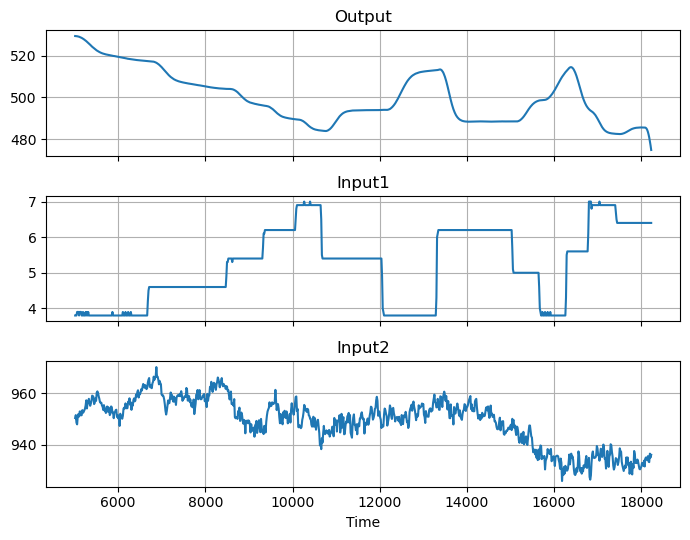

In [4]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 5.5))

data = input_output_data.set_index('Time')

for ax, name in zip(axes, data.columns):
    data[name].plot(ax=ax, grid=True, title=name)

plt.tight_layout()
plt.show()

## Implement Simulation Function

Original VBA code from Russ

```basic
Ndelay=INT(thetamodel/dt + 0.5)                         ‘discretized model delay
clambda = Exp(-dt / Taumodel)                                             ‘model coefficient
lambda = 1 – clambda                                               ‘complement to model coefficient
ymodeldev = Yinitial – Ybase                                  ‘initial deviation variable value for model
SSD = 0                                                                                          ‘initialize the Sum of Squared Deviations
For DataNumber = Ndelay + 1 To Ndata                            ‘start with first value after the delay
                influence = udata(DataNumber - Ndelay) – Ubase                       ‘calculate influence
                ymodeldev = lambda * Kmodel * influence + clambda * ymodeldev               ‘model
                ymodel(DataNumber) = ymodeldev + Ybase                                  ‘convert to CV
                SSD = SSD + (ymodel(DataNumber) – ydata(DataNumber))^2 ‘sum d^2
Next DataNumber
```

In [5]:
input_col = 'Input1'
t = input_output_data['Time'].to_numpy()
u_data = input_output_data[input_col].to_numpy()
y_data = input_output_data['Output'].to_numpy()

# Determine average time interval
time_step_sizes = np.diff(t)
dt = np.mean(time_step_sizes)
assert np.max(np.abs(time_step_sizes - dt)) < dt / 10
dt

np.float64(15.02181818181818)

In [6]:
# Make simulation function
simulate = make_simulate_function(dt, u_data)

# Test simulate function
K = -10.0
tau = 400.0 
n_delay = 2  # must be integer 
y_base = 500.0
u_base = 5.0
y_init = 500.0

y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)
prediction_error(y_model[n_delay+1:], y_data[n_delay+1:])

np.float64(27352.792889210206)

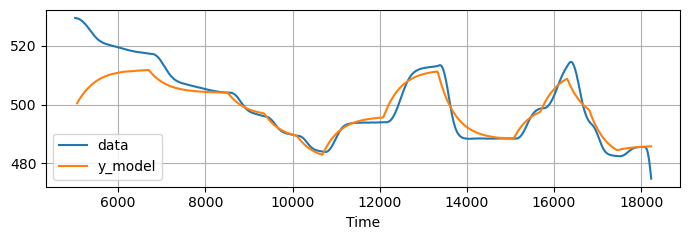

In [7]:
plt.figure(figsize=(7, 2.5))
plt.plot(t, input_output_data["Output"].to_numpy(), label='data')
plt.plot(t, y_model, label='y_model')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
%timeit y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)

2.55 μs ± 11.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Construct Optimization Problem Class

In [9]:
bounds = calculate_reasonable_bounds(t, u_data, y_data)
var_names = list(bounds.keys())
bounds = list(bounds.values())
bounds

[(np.float64(-85.37499999999989), np.float64(85.37499999999989)),
 (np.float64(15.02181818181818), np.float64(4406.4)),
 (0, 88),
 (np.float64(390.72511918274705), np.float64(609.2851191827467)),
 (np.float64(-1.1950056753688987), np.float64(11.604994324631102)),
 (np.float64(474.79), np.float64(584.0699999999999))]

In [10]:
problem = SysIdFOPDT(bounds, dt, u_data, y_data)

# Test cost function evaluation
x = [K, tau, n_delay, y_base, u_base, y_init]
ssd = problem.cost_function_to_minimize(x)
ssd

np.float64(27352.792889210206)

In [11]:
# Global minimum
K, tau, n_delay, y_base, u_base, y_init = [-12.250, 443.053, 4, 477.937, 6.853, 533.770]
x_global_minimum = K, tau, n_delay, y_base, u_base, y_init
print(problem.cost_function_to_minimize(x_global_minimum))

4607.531364465804


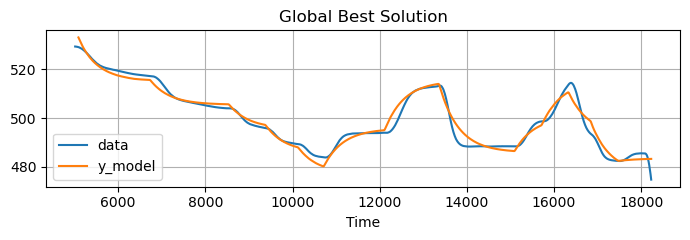

In [12]:
y_model = simulate(K, tau, n_delay, y_base, u_base, y_init)

plt.figure(figsize=(7, 2.5))
plt.plot(t, input_output_data["Output"].to_numpy(), label='data')
plt.plot(t, y_model, label='y_model')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.title('Global Best Solution')
plt.tight_layout()
plt.show()

In [13]:
sol = solve_problem_with_optimizer(
    problem, 
    lpfgopt.minimize, 
    problem.bounds,
    discrete=[2],
    tol=0.1,
    maxit=1000,
    seedval=0
)
sol

        best: [np.float64(5023.073010648378), np.float64(-12.510551738201487), np.float64(504.88903168689944), 1, np.float64(445.1508234584575), np.float64(9.432454281366677), np.float64(533.4755488960836)]
 final_error: np.float64(0.0919957657106671)
         fun: np.float64(5023.073010648378)
       maxcv: 0
     message: 'Tolerance condition satisfied'
        nfev: 672
         nit: 652
    pointset: [[np.float64(5023.8750935926855), np.float64(-12.514670819290698), np.float64(504.95420042851964), 1, np.float64(445.14195954217), np.float64(9.434436665565526), np.float64(533.5327402843525)], [np.float64(5023.447269574699), np.float64(-12.518196190199113), np.float64(504.91710023542987), 1, np.float64(445.0456910228489), np.float64(9.43783490251223), np.float64(533.6028209148216)], [np.float64(5024.674309273745), np.float64(-12.523524934906348), np.float64(506.1645675832492), 1, np.float64(445.00378038499565), np.float64(9.436639590153336), np.float64(533.529286231721)], [np.float64(

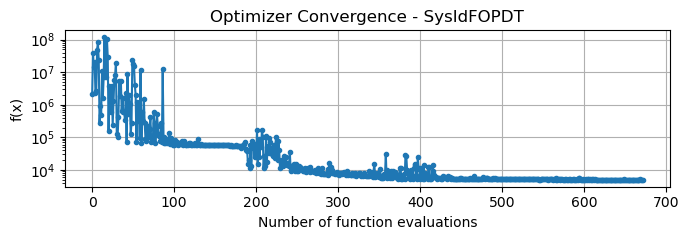

In [14]:
convergence_plot(problem)
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


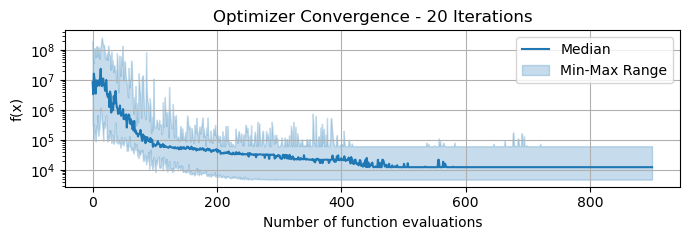

In [15]:
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem, 
    lpfgopt.minimize, 
    20, 
    problem.bounds,
    discrete=[2],
    tol=0.1,
    maxit=1000,
)
ax = convergence_plot_n_repeats(fun_evals)
plt.tight_layout()
plt.show()

In [16]:
min(best_guesses)

(np.float64(4724.496180635404),
 [np.float64(-12.352624501265591),
  np.float64(464.28669634697087),
  3,
  np.float64(501.7244294857218),
  np.float64(4.911495406866806),
  np.float64(533.5615291692585)])

## Bayesian Optimization

In [17]:
# Define your original dimensions
dimensions = [
    Real(np.float64(-85.37499999999989), np.float64(85.37499999999989), transform='normalize'),
    Real(np.float64(15.02181818181818), np.float64(4406.4), transform='normalize'),
    Integer(0, 10),  # Integers don't need/support transform parameter
    Real(np.float64(390.72511918274705), np.float64(609.2851191827467), transform='normalize'),
    Real(np.float64(-1.1950056753688987), np.float64(11.604994324631102), transform='normalize'),
    Real(np.float64(474.79), np.float64(584.0699999999999), transform='normalize')
]

dimensions

[Real(low=-85.37499999999989, high=85.37499999999989, prior='uniform', transform='normalize'),
 Real(low=15.02181818181818, high=4406.4, prior='uniform', transform='normalize'),
 Integer(low=0, high=10, prior='uniform', transform='identity'),
 Real(low=390.72511918274705, high=609.2851191827467, prior='uniform', transform='normalize'),
 Real(low=-1.1950056753688987, high=11.604994324631102, prior='uniform', transform='normalize'),
 Real(low=474.79, high=584.0699999999999, prior='uniform', transform='normalize')]

In [18]:
# Check including integer value works
problem([-12.2499176 , 443.05302818,  4, 477.93684621, 6.8525689 , 533.76953308])

np.float64(4607.505439136009)

In [19]:
# Run Bayesian optimization
# 500 iterations takes ___ mins
problem.reset()
res = skopt.gp_minimize(
    problem,
    dimensions,
    n_calls=250,
    noise=1e-10,
    random_state=0,
    n_initial_points=20,
    verbose=True
)
res

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0010
Function value obtained: 1809331.9362
Current minimum: 1809331.9362
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0006
Function value obtained: 15841226.2136
Current minimum: 1809331.9362
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0005
Function value obtained: 771340.2073
Current minimum: 771340.2073
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0007
Function value obtained: 5824577.8797
Current minimum: 771340.2073
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0005
Function value obtained: 39519702.9465
Curren

          fun: 7681.500282081621
            x: [-12.75157584445678, 621.8664277989981, np.int64(1), 428.3006589897249, 10.538959460774903, 537.6691579270245]
    func_vals: [ 1.809e+06  1.584e+07 ...  3.949e+05  1.225e+04]
      x_iters: [[15.853218561921878, 3722.5120061568928, np.int64(9), 575.9004592114053, 6.786609643491549, 516.7952329729462], [-34.5709659325313, 264.06994939958764, np.int64(3), 495.12360722450114, 9.200754052957418, 527.2419053971463], [-18.30699606578328, 3686.5598586613814, np.int64(3), 532.3895635382565, 3.518486034590116, 579.3879157703889], [-61.410104244540754, 3835.904020815056, np.int64(5), 565.7721731354179, 5.467106062886525, 548.9779550513999], [37.673025794450254, 2570.8908344867987, np.int64(5), 556.5281500346412, 0.16061169663484098, 526.5450538262028], [-53.55875237695566, 3251.1082230111515, np.int64(2), 420.2784031622426, 2.9539992243842423, 491.1464694858329], [-47.41362295604134, 1712.2410974110678, np.int64(9), 489.06618897774484, 6.652206585

In [20]:
res['x'], res['fun']

([-12.75157584445678,
  621.8664277989981,
  np.int64(1),
  428.3006589897249,
  10.538959460774903,
  537.6691579270245],
 np.float64(7681.500282081621))

In [21]:
problem.best_guess

(np.float64(7681.500282081621),
 [-12.75157584445678,
  621.8664277989981,
  np.int64(1),
  428.3006589897249,
  10.538959460774903,
  537.6691579270245])

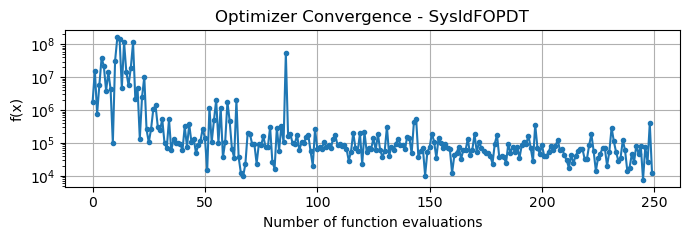

In [22]:
convergence_plot(problem)
plt.tight_layout()
plt.show()

In [23]:
fun_evals, unique_solutions, best_guesses = solve_problem_with_optimizer_n_repeats(
    problem, 
    skopt.gp_minimize, 
    10,
    dimensions,
    noise=1e-10,
    n_calls=250,
    n_initial_points=20,
)
unique_solutions

100%|██████████| 10/10 [2:02:44<00:00, 736.47s/it]


Counter({(-9.337492, 1806.239077, 9.0, 503.146787, 3.990516, 532.55866): 1,
         (-13.629058, 306.194532, 3.0, 502.661796, 4.802069, 534.590717): 1,
         (-11.665911, 358.623927, 9.0, 543.020935, 1.36105, 537.409695): 1,
         (-12.760895, 496.597942, 7.0, 466.353413, 7.568897, 534.046128): 1,
         (-12.539828, 437.074147, 4.0, 491.742917, 5.660071, 532.352085): 1,
         (-9.317238, 264.523553, 5.0, 557.036753, -0.830634, 542.614822): 1,
         (-9.3672, 618.60321, 9.0, 536.422819, 1.107958, 519.297876): 1,
         (-11.224722, 478.728083, 9.0, 534.755152, 1.947023, 535.55042): 1,
         (-11.724055, 305.310984, 8.0, 458.901497, 8.562942, 522.599153): 1,
         (-11.284002, 320.910549, 10.0, 526.963684, 2.66068, 536.759496): 1})

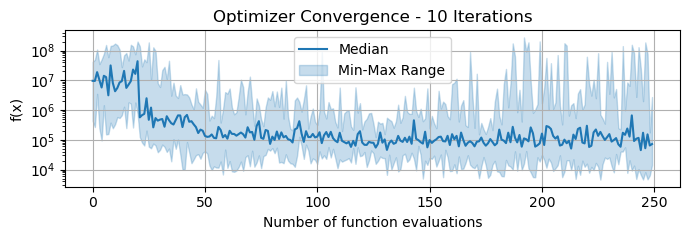

In [44]:
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

ax = convergence_plot_n_repeats(fun_evals)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "convergence_plot_10.png"), dpi=150)
plt.show()

In [25]:
min(best_guesses)

(np.float64(4599.471298221973),
 [-11.665911260667073,
  358.6239274245781,
  np.int64(9),
  543.0209354680447,
  1.3610498576193484,
  537.4096952960914])

In [43]:
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Save results
np.save(os.path.join(results_dir, "fun_evals.npy"), np.stack(fun_evals))
best_guesses_x = np.stack([item[1] for item in best_guesses])
assert best_guesses_x.shape == (10, 6)
np.save(os.path.join(results_dir, "best_guesses_x.npy"), best_guesses_x)
best_guesses_fun = np.stack([item[0] for item in best_guesses])
assert best_guesses_fun.shape == (10,)
np.save(os.path.join(results_dir, "best_guesses_fun.npy"), best_guesses_fun)